In [1]:
import pandas as pd
from matplotlib.figure import Figure

df = pd.read_csv("../src_data/cross_dedup_refinedweb_filtered.csv")
df

runname  seed   steps  agg_score  \
0    big-run-sampled_full_filtered_no_dedup     6       0   0.330893   
1    big-run-sampled_full_filtered_no_dedup     6    1000   0.360520   
2    big-run-sampled_full_filtered_no_dedup     6    2000   0.373315   
3    big-run-sampled_full_filtered_no_dedup     6    3000   0.388201   
4    big-run-sampled_full_filtered_no_dedup     6    4000   0.393412   
..                                      ...   ...     ...        ...   
501       big-run-fineweb-cross-dedup-fixed     6  163000   0.466306   
502       big-run-fineweb-cross-dedup-fixed     6  164000   0.468313   
503       big-run-fineweb-cross-dedup-fixed     6  165000   0.468639   
504       big-run-fineweb-cross-dedup-fixed     6  166000   0.465767   
505       big-run-fineweb-cross-dedup-fixed     6  167000   0.469262   

     commonsense_qa/acc  commonsense_qa/acc_norm  hellaswag/acc  \
0                 0.186                    0.233          0.272   
1                 0.254                    0.260          0.290   
2                 0.285                    0.278          0.315   
3                 0.294                    0.291          0.327   
4                 0.306                    0.307          0.337   
..                  ...                      ...            ...   
501               0.391                    0.371          0.459   
502               0.395                    0.374          0.459   
503               0.397                    0.374          0.450   
504               0.412                    0.375          0.458   
505               0.399                    0.377          0.459   

     hellaswag/acc_norm  openbookqa/acc  openbookqa/acc_norm  ...  siqa/acc  \
0                 0.258           0.166                0.286  ...     0.367   
1                 0.281           0.138                0.256  ...     0.362   
2                 0.323           0.138                0.272  ...     0.365   
3                 0.341           0.152                0.298  ...     0.371   
4                 0.360           0.172                0.284  ...     0.380   
..                  ...             ...                  ...  ...       ...   
501               0.547           0.210                0.344  ...     0.401   
502               0.548           0.208                0.350  ...     0.402   
503               0.548           0.208                0.358  ...     0.400   
504               0.552           0.214                0.348  ...     0.403   
505               0.550           0.220                0.348  ...     0.406   

     siqa/acc_norm  winogrande/acc  winogrande/acc_norm  sciq/acc  \
0            0.362           0.516                0.497     0.209   
1            0.400           0.517                0.524     0.573   
2            0.395           0.509                0.490     0.677   
3            0.396           0.512                0.504     0.712   
4            0.402           0.522                0.510     0.729   
..             ...             ...                  ...       ...   
501          0.388           0.564                0.562     0.884   
502          0.395           0.559                0.561     0.876   
503          0.391           0.552                0.556     0.876   
504          0.398           0.551                0.553     0.877   
505          0.401           0.564                0.560     0.882   

     sciq/acc_norm  arc/acc  arc/acc_norm  mmlu/acc  mmlu/acc_norm  
0            0.202   0.2195        0.2510  0.230294       0.250147  
1            0.515   0.2675        0.2895  0.239489       0.251660  
2            0.596   0.3075        0.3235  0.250318       0.261019  
3            0.621   0.3220        0.3390  0.255646       0.266605  
4            0.612   0.3100        0.3385  0.253048       0.266798  
..             ...      ...           ...       ...            ...  
501          0.807   0.4535        0.4450  0.300475       0.320448  
502          0.795   0.4540        0

In [13]:
runs_mapping = {
    "big-run-refinedweb": "RefinedWeb",
    "big-run-fineweb-cross-dedup-fixed": "FineWeb full MinHash",
    "big-run-sampled_full_filtered_no_dedup": "FineWeb filtered only"
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


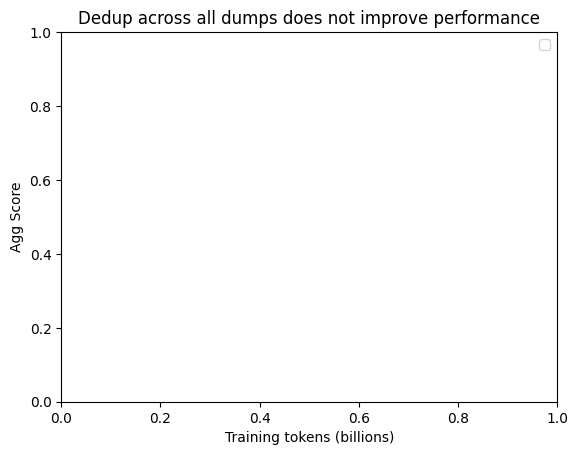

In [15]:
from matplotlib import pyplot as plt
from matplotlib import pyplot as plt

import json
import os
from matplotlib import pyplot as plt
metrics = ['agg_score', 'commonsense_qa/acc_norm', 'hellaswag/acc_norm', 'openbookqa/acc_norm', 'piqa/acc_norm',
                   'siqa/acc_norm', 'winogrande/acc_norm', 'arc/acc_norm', 'mmlu/acc_norm']

def normalize_runname(runname):
    return runname.replace("/", "_")

grouped = (
    df.groupby(["runname", "steps"])
    .agg(
        {
            key: "mean" for key in metrics
        }
    )
    .reset_index()
)

file_id="../assets/data/plots/all_dumps_bad"
files = {}
for metric in metrics:
    datas = {}
    for name, group in grouped.groupby("runname"):
        # if name not in runs_mapping:
        #     continue
        group = group[["steps", metric]].sort_values(by="steps")
        group = group.set_index("steps")
        rolling_avg = group
        # rolling_avg = group.rolling(window=5).mean()
        datas[name] = {
            "x": (rolling_avg.index * 2048 * 1024 * 1e-9).tolist(),
            "y": rolling_avg[metric].tolist(),
            "label": runs_mapping[name],
        }
    # Sort the datata based on the steps
    datas = {k: v for k, v in sorted(datas.items(), key=lambda x: -x[1]["y"][-1])}
    # Create a folder
    os.makedirs(f"{file_id}", exist_ok=True)
    with open(f"{file_id}/{normalize_runname(metric)}.json", "w") as f:
        json.dump({
            "data": datas,
            "layout": {
                "title": {
                    "text": "Dedup across all dumps does not improve performance"
                },
            }
        }, f)
    files[metric] = {"file": f"{normalize_runname(metric)}.json"}
# Create index
with open(f"{file_id}/index.json", "w") as f:
    json.dump({
        "files": files,
        "settings": {
            "defaultMetric": "agg_score",
            "slider":{"min":0,"max":30,"default":5}
        }
    }, f)
# Add labels and legend
plt.xlabel('Training tokens (billions)')
plt.ylabel('Agg Score')
plt.title('Dedup across all dumps does not improve performance')
plt.legend()

# Show the plot
plt.show()